# Consensus Peak Set

**Created**: 10 November 2021

## Environment

In [1]:
rm(list=ls())

library(tidyverse)
library(data.table)
library(RColorBrewer)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




## Load Data

In [2]:
consensus.peak.set <- fread("~/gains_team282/epigenetics/calderon_et_al/analysis/atac_seq/consensus_peaks.bed")
colnames(consensus.peak.set) <- c("Chr", "Start", "End", "Peak.Count", "Fold.Enrichment", "Log.10.P.Value", "Log.10.Q.Value", "Point.Source")

In [3]:
head(consensus.peak.set)

Chr,Start,End,Peak.Count,Fold.Enrichment,Log.10.P.Value,Log.10.Q.Value,Point.Source
<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>
1,23224,23849,16,"4.28058,3.2194,4.208,3.98217,3.92794,3.15589,3.48806,3.1049,3.85866,3.69904,3.30981,3.54142,3.9167,3.47732,2.80505,3.79488","6.59463,4.1491,6.20772,5.59157,5.74531,4.23228,4.38417,3.7889,5.87431,4.70962,4.69377,5.09351,5.97469,4.56283,3.63025,5.28916","4.44366,2.09827,4.25009,3.65281,3.73148,2.36646,2.3039,1.69059,3.55506,2.85053,2.8227,3.09427,4.01614,2.54472,1.92994,2.96611","59,23,26,24,20,79,89,94,39,64,39,99,324,56,141,84"
1,24025,26778,91,"4.96392,4.07795,3.86784,4.36876,3.48806,4.97571,2.84187,3.83654,3.89013,3.4142,2.95082,3.50028,3.08738,4.20312,4.17215,4.41357,3.2194,4.44137,4.45016,4.00128,3.31506,3.86145,4.4523,4.83708,3.32955,4.78858,4.95489,3.91001,4.08058,3.61825,4.01659,4.25479,3.86784,3.69687,3.18001,3.18653,3.20376,3.83654,3.31504,3.29087,3.63324,3.08087,3.33723,3.99647,3.54566,3.92227,4.65075,3.56184,4.81232,3.35704,4.27814,5.11737,3.24918,4.52052,4.07851,3.61825,2.98664,3.10018,4.44137,4.99111,3.31413,3.91869,3.60062,4.25479,4.20332,5.0859,2.94233,3.31504,3.33039,3.92227,3.50646,5.36697,4.65641,5.01149,3.99761,3.44009,3.61542,3.85866,8.6311,4.02396,5.34775,4.22325,4.08007,4.96392,4.07795,3.94917,4.52141,3.91001,2.90252,4.06147,4.33087","8.03312,6.25131,5.18023,7.3091,4.38417,8.05279,4.02998,5.83595,5.92879,4.46209,3.88257,6.15715,4.1161,5.94526,7.23278,6.81764,4.1491,6.86404,7.16338,6.37911,4.91042,6.12912,7.45791,7.82071,4.52405,8.04788,7.13479,5.96314,5.51357,5.00131,6.4063,6.28432,5.18023,4.5242,4.27304,4.09596,4.31309,5.83595,4.11626,4.26433,5.71448,4.29077,4.53686,5.85914,4.67155,5.49513,6.92626,5.12839,8.40482,4.7759,6.59052,9.62117,3.84509,6.99576,5.29433,5.00131,4.48769,4.5159,6.86404,7.76889,4.4983,5.97812,4.9724,6.28432,5.48723,8.88856,3.69754,4.11626,4.32784,5.49513,4.81757,10.4373,7.22067,8.11244,6.37258,4.70787,5.21968,5.87431,17.02,5.65869,8.34623,5.97733,7.05882,8.03312,6.25131,6.2863,6.99724,5.96314,3.63195,5.48369,5.68504","5.45709,3.89483,3.02459,5.37149,2.3039,5.31757,2.09212,3.7632,3.74281,2.56337,2.14095,4.15862,2.35869,3.91473,5.17167,4.60727,2.09827,4.62994,5.05039,4.15625,3.12335,4.1172,4.97891,5.83718,2.55733,5.78724,4.85199,3.73649,2.97003,2.93889,4.33777,3.82037,3.02459,2.32367,2.7893,2.24604,2.52153,3.7632,2.15083,2.07474,3.60747,2.55714,2.60822,3.67935,2.36628,3.63531,4.64921,2.91431,6.04925,2.74324,4.2035,7.82078,1.83091,4.8374,3.25323,2.93889,2.49306,2.55913,4.62994,5.56656,2.62549,3.58061,3.01542,3.82037,2.99392,6.71037,1.69631,2.15083,2.26407,3.63531,2.7237,8.41512,5.18962,6.00256,4.2741,2.82651,3.29989,3.55506,14.7883,3.64553,6.30138,3.85847,5.18327,5.45709,3.89483,4.35233,4.63579,3.73649,1.91547,3.26924,3.24065","57,846,96,174,181,88,158,210,209,247,154,69,76,151,83,282,16,25,157,56,25,63,98,62,388,131,377,55,65,162,220,81,71,93,168,76,23,105,91,131,418,27,98,105,36,154,114,405,33,131,187,322,14,129,156,180,55,87,105,102,72,58,75,130,94,159,140,67,36,161,131,90,64,70,69,43,58,81,42,115,30,91,34,63,31,41,253,36,115,59,47"
1,28647,30136,183,"179.083,67.2284,117.321,76.2148,50.3935,85.9352,92.1023,66.3851,179.754,133.026,80.3889,75.719,66.174,62.8299,75.6431,61.6393,234.328,52.113,170.078,79.432,100.795,107.224,96.8457,154.758,117.054,190.82,149.591,84.4672,183.047,74.1736,144.335,45.6409,29.8547,107.798,88.542,73.0367,200.435,58.6445,60.7769,80.3538,76.6057,76.6042,87.2918,73.5698,188.486,139.626,69.0663,126.366,55.559,43.8322,124.837,90.2244,135.636,38.5983,88.9727,73.428,143.33,113.704,33.2221,41.7592,142.048,125.008,83.9803,84.9816,77.8157,96.8181,66.921,59.8182,35.819,83.702,60.9835,33.2634,91.7893,41.3715,29.2367,48.8721,32.3535,62.4339,86.7981,93.4689,97.2515,30.1021,69.3612,65.8227,108.864,45.4089,93.1032,109.766,64.1685,37.1523,35.4399,45.5975,36.2203,97.0653,118.35,13.3569,70.1431,34.7298,30.6445,15.9569,67.6321,128.646,94.8574,25.9132,36.4455,120.057,24.7079,16.4548,46.091,76.4078,43.9907,79.5392,53.878,123.562,16.868

In [4]:
chr.lengths <- read.table("~/gains_team282/epigenetics/star_genome_index/chrNameLength.txt")
colnames(chr.lengths) <- c("Chr", "Chr.Length")
rownames(chr.lengths) <- chr.lengths$Chr

In [5]:
head(chr.lengths)

,Chr,Chr.Length
,<chr>,<int>
1,1,248956422
10,10,133797422
11,11,135086622
12,12,133275309
13,13,114364328
14,14,107043718


## General Summary

There are $n=1347371$ peaks in the final set.

In [6]:
nrow(consensus.peak.set)

[1] 1347371

## Peaks per Chromosome

To see if there is a bias for certain chromosomes over other, I calculate the number of peaks per Mb of the chromosome. The data looks relatively consistent other than the Y chromosome, where few peaks were counted.

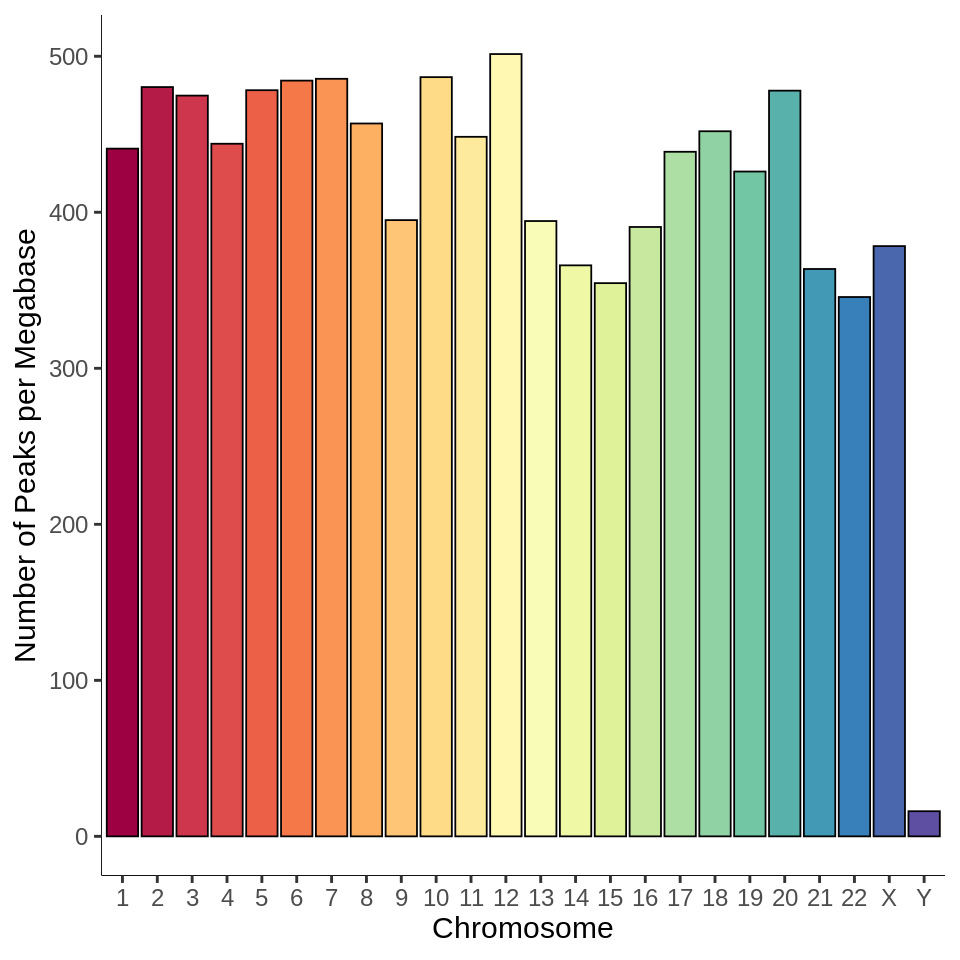

In [7]:
options(repr.plot.width=8, repr.plot.height=8)
consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::group_by(Chr) %>%
    dplyr::summarize(N.Peaks=n()) %>%
    dplyr::filter(Chr %in% c(1:22, "X", "Y")) %>%
    dplyr::mutate(Chr=factor(Chr, levels=c(1:22, "X", "Y"))) %>%
    merge(., chr.lengths, by="Chr") %>%
    dplyr::mutate(Normalized.N.Peaks=N.Peaks / Chr.Length * 10^6) %>%
    ggplot() +
    geom_bar(aes(x=Chr, y=Normalized.N.Peaks, fill=Chr), color="black", stat="identity") +
    scale_fill_manual(values=colorRampPalette(brewer.pal(11, "Spectral"))(24)) +
    xlab("Chromosome") + ylab("Number of Peaks per Megabase") +
    guides(fill="none") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_per_chromosome.svg", width=8, height=8)

## Peak Width

The peak size was restricted to below 3 kb. Any intersecting peaks that formed broad peaks (> 3 kb) should be pruned. The median peak size is 429. The distribution is skewed to the right, but in general the number of peaks approaching 3 kb is pretty small.

In [8]:
peak.width.data <- consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::mutate(Peak.Size=End-Start)
median(peak.width.data$Peak.Size)

[1] 429

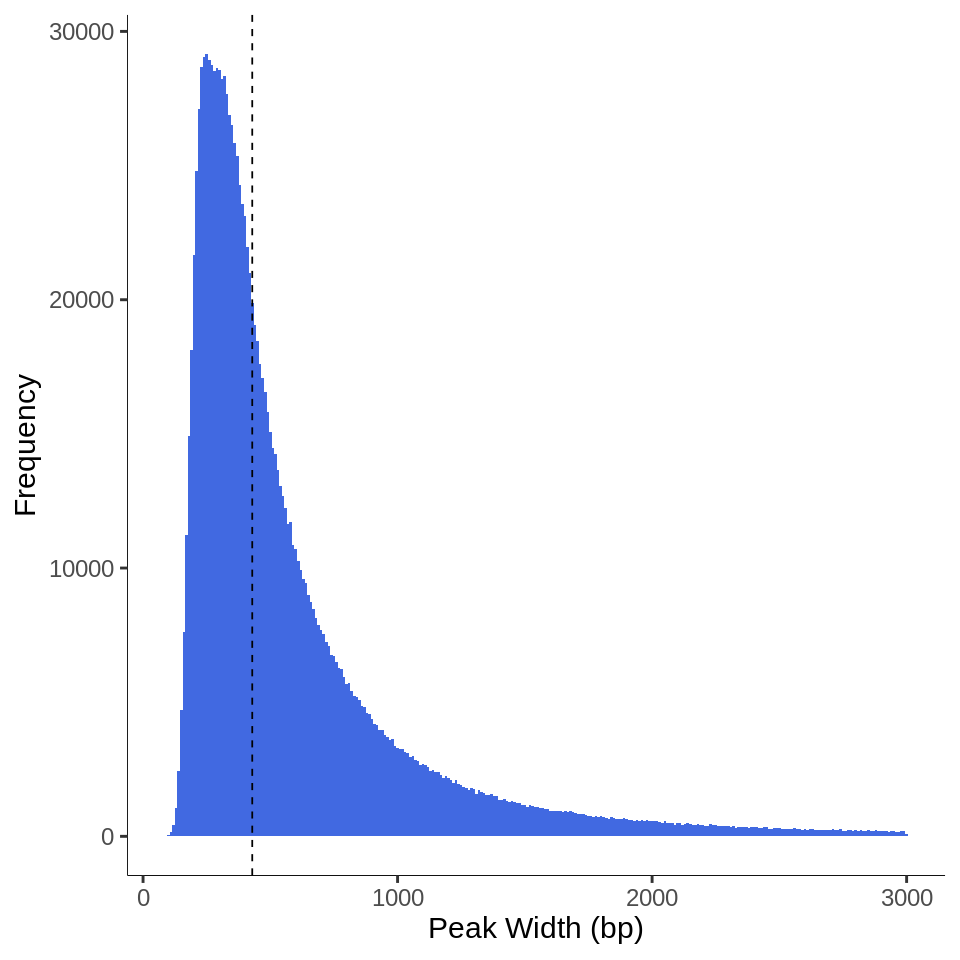

In [9]:
options(repr.plot.width=8, repr.plot.height=8)
peak.width.data %>%
    ggplot() +
    geom_histogram(aes(x=Peak.Size), binwidth=10, fill="royalblue") +
    geom_vline(xintercept=median(peak.width.data$Peak.Size), lty=2) +
    xlab("Peak Width (bp)") + ylab("Frequency") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_peak_width.svg", width=8, height=8)

## Counts of Peaks Merged

The median number of peaks being merged into a final peak in the consensus set is 4.

In [88]:
median(consensus.peak.set$Peak.Count)

[1] 4

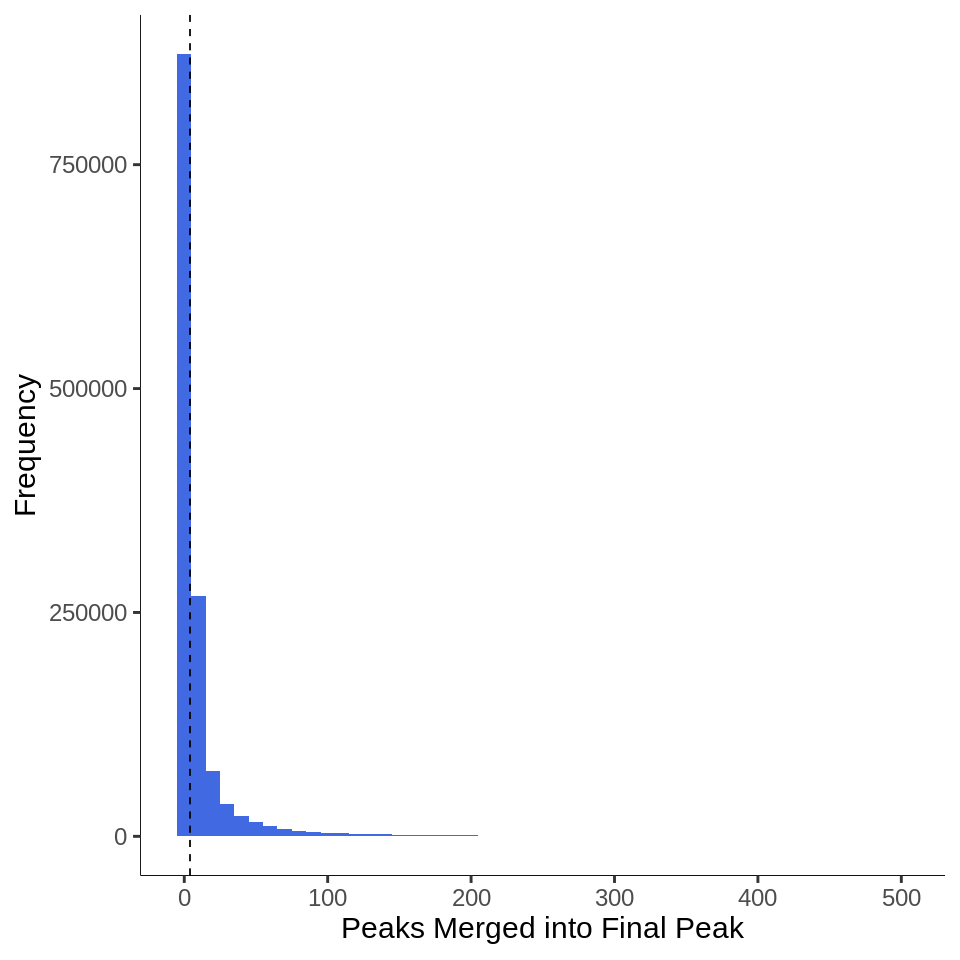

In [89]:
options(repr.plot.width=8, repr.plot.height=8)
consensus.peak.set %>%
    as.data.frame() %>%
    ggplot() +
    geom_histogram(aes(x=Peak.Count), binwidth=10, fill="royalblue") +
    geom_vline(xintercept=median(peak.width.data$Peak.Count), lty=2) +
    xlab("Peaks Merged into Final Peak") + ylab("Frequency") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_peak_count.svg", width=8, height=8)

It would be ideal if the number of peaks merging into the final peak does not increase the width of the peak. However, there is an association between final peak width and number of peaks merged to form the final peak.

There is an interesting repeating pattern when the count exceeds 175 (the number of ATAC peaks). By the pigeonhole principle, all these peaks merge at least two peaks from one sample. 

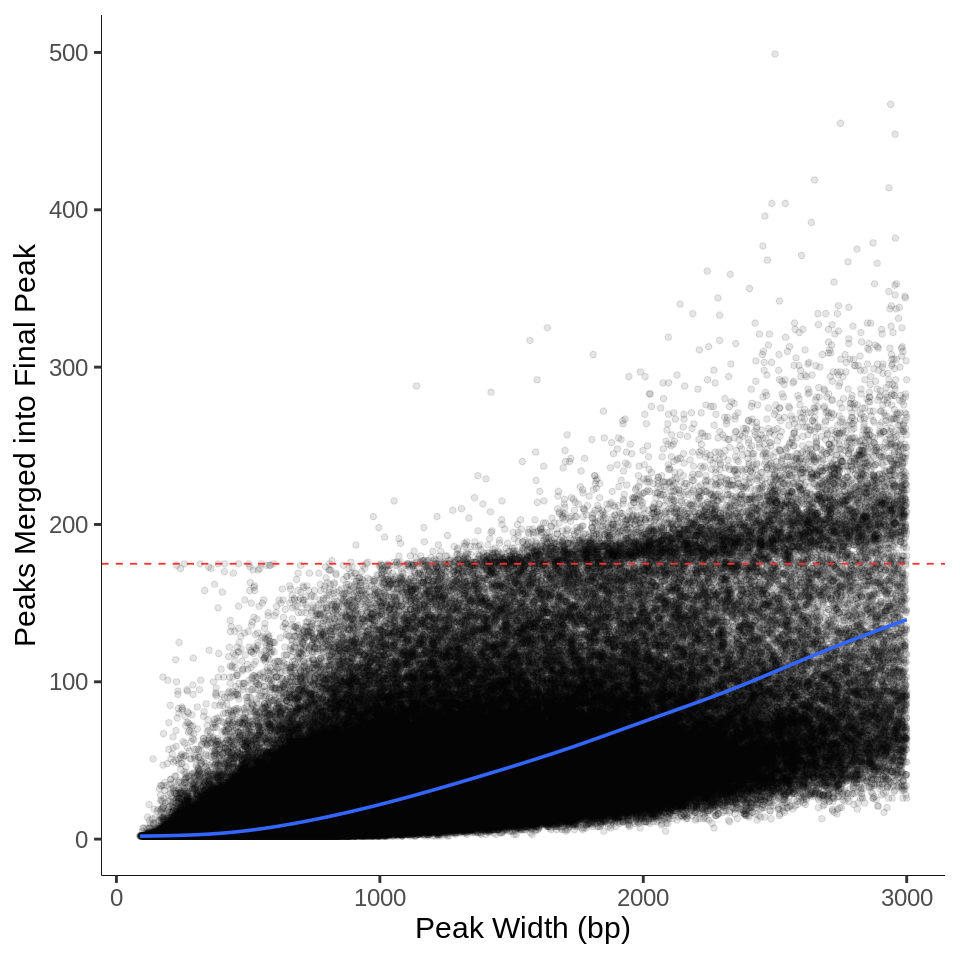

In [102]:
options(repr.plot.width=8, repr.plot.height=8)
consensus.peak.set %>%
    as.data.frame() %>%
    dplyr::mutate(Peak.Size=End-Start) %>%
    ggplot(aes(x=Peak.Size, y=Peak.Count)) +
    geom_point(alpha=0.1) +
    geom_smooth(method="gam", formula=y~s(x + 0, bs="cs")) +
    geom_hline(yintercept=175, lty=2, color="firebrick1") +
    xlab("Peak Width (bp)") + ylab("Peaks Merged into Final Peak") +
    ggplot_theme
ggsave("03_Functional_Interpretation/results/consensus_peaks_peak_counts_by_width.png", width=8, height=8, dpi=600)